<a href="https://colab.research.google.com/github/yanhao5103233729/github-colab/blob/main/hw2%20-%20%5BFall%202023%5D%20Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2: Resnet

Credit: Sohom Paul, Saathvik Selvan, Aryan Jain

In lecture you've seen a history of neural network architectures. In this notebook, we will be implementing one of the most important CNN architectures of the past few years - the ResNet.

For further refernce on ResNet, you can refer to the [original paper](https://arxiv.org/pdf/1512.03385.pdf) or you can read this [fantastic blog post](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8) on the subject.

In [3]:
import time
import os

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets

from tqdm.notebook import tqdm

import numpy as np
from matplotlib import pyplot as plt
from random import randint

### Part 1: Loading the Data

Recall that `torchvision` gives us direct access to common datasets, which saves us from downloading the data ourselves and writing a custom `DataLoader`. This is really handy for when you're doing some quick prototyping or doing research. We will be using the classic CIFAR-10 dataset. This function may take a few seconds to run because it needs to download the dataset from the internet.

In [7]:
batch_size = 32
data_root = './data/cifar10'
transform = T.Compose([
    T.ToTensor(),
    # scales pixel values to range [-1, 1]
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_size = 40_000
val_size = 10_000

In [9]:
dataset = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform,
)
assert train_size + val_size <= len(dataset), "Trying to sample too many elements!" \
    "Please lower the train or validation set sizes."
train_set, val_set, _ = torch.utils.data.random_split(
    dataset, [train_size, val_size, len(dataset) - train_size - val_size]
)
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck',
)

100%|██████████| 170498071/170498071 [00:02<00:00, 70765211.01it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


In [10]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

showing training images


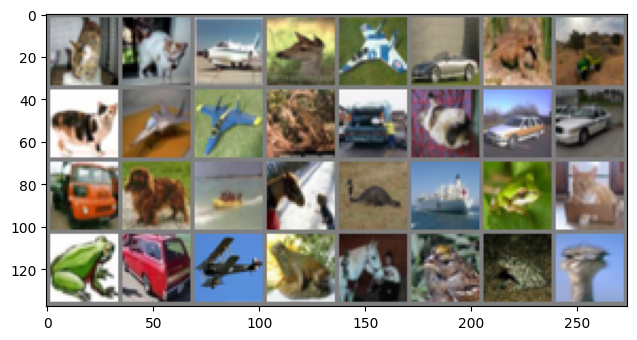


... and their corresponding labels
cat      cat      plane    deer     plane    car      frog     truck   
cat      plane    plane    frog     truck    cat      car      car     
truck    dog      ship     horse    bird     ship     frog     cat     
frog     car      plane    frog     horse    bird     frog     bird    


In [11]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.5, 7.5]

def show_image(img):
    img = img / 2 + 0.5
    img = img.numpy()
    img = img.transpose([1, 2, 0])
    plt.imshow(img)
    plt.show()

images, labels = next(iter(train_loader))
nrow = 4
print('showing training images')
show_image(torchvision.utils.make_grid(images, nrow=batch_size // nrow))
print('\n... and their corresponding labels')
for idxs in np.array_split(np.arange(batch_size), nrow):
    print(' '.join(f'{classes[labels[j]]:8s}' for j in idxs))

### Part 2: Fully Connected Neural Network

The most basic neural network structure is a fully-connected neural network. This means that every neuron in each layer is connected to every neuron in the previous layer. Let's try implementing one.

In [20]:
class FCNN(nn.Module):
    def __init__(self, layer_dims):
        '''
        Initialize the torch.nn.Module and define some layers for future ues
        layer_dims: list of integers, representing the width
            of each of the layers of our NN. For simplicity, you may assume
            that len(layer_dims) == 3
        '''
        ## YOUR CODE HERE
        ## TODO: Remember your call to super!
        ## TODO: Create some linear layers you can use in foward
        ## You may either hard-code that there will be 3 layers,
        ## or you can look into torch.nn.ModuleList()
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(layer_dims[0], layer_dims[1])
        self.fc2 = nn.Linear(layer_dims[1], layer_dims[2])
        ## END YOUR CODE

    def forward(self, x):
        '''
        Compute a forward pass of your batch of images

        x: torch.Tensor of shape (batch_size, num_channels, width, height)
        returns: result of passing x through your network
        '''
        ## YOUR CODE HERE
        ## TODO: Flatten the images; remeber that x has a whole batch!
        ## TODO: Apply each of the layers and relu after each one
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x
        ## END YOUR CODE

Here you will get a chance to implement parts of our training and validation loops. If you find yourself struggling, take a look at the training loop from the first homework -- these loops are usually pretty standard and have many similarities regardless of the model.

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def compute_accuracy(model, loader):
    total_correct = 0

    ## YOUR CODE HERE
    ## TODO: Put the model on our device (may not always be CPU)
    ## TODO: Enable eval mode on the model
    model.to(device)
    model.eval()
    ## END YOUR CODE

    for inputs, labels in tqdm(loader, leave=False):
        ## YOUR CODE HERE
        ## TODO: Put the inputs and labels on our device
        ## TODO: Compute the model outputs
        ## TODO: Calculate the number of correct predictions (hint: use torch.argmax)
        ## TODO: Update the total number of correct predictions
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        total_correct += torch.sum(predictions == labels).item()
        ## END YOUR CODE
    return total_correct / len(loader.dataset)

def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, path = None, scheduler = None):
    print('beginning to train model')
    if path and not os.path.exists(path):
      os.makedirs(path)

    ## YOUR CODE HERE
    ## TODO: Put the model on our device (may not always be CPU)
    model.to(device)
    ## END YOUR CODE

    for epoch in tqdm(range(1, num_epochs + 1)):
        model.train()
        total_loss = 0
        start_time = time.perf_counter()
        for inputs, labels in tqdm(train_loader, leave=False):
            ## YOUR CODE HERE
            ## TODO: Put the inputs and labels on our device
            ## TODO: Zero out the gradients
            ## TODO: Compute the model outputs
            ## TODO: Calculate the loss
            ## TODO: Backpropagate the loss
            ## TODO: Perform an optimizer step
            ## TODO: Update the total loss with the current loss
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            ## END YOUR CODE

        if path:
          torch.save(model.state_dict(), f'{path}/model_ep_{epoch:02d}.pth')
        end_time = time.perf_counter()
        duration = end_time - start_time

        ## YOUR CODE HERE
        ## TODO: Compute the training and validation accuracies (hint: use compute_accuracy())
        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, val_loader)
        ## END YOUR CODE

        current_lr = optimizer.param_groups[0]['lr']

        if scheduler and current_lr > 5e-5:
            scheduler.step()

        print(f'epoch {epoch:2}',
              f'loss: {total_loss:.3f}',
              f'time: {duration:.3f}',
              f'train acc: {train_acc:.4f}',
              f'val acc: {val_acc:.4f}', sep='\t')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
num_epochs = 15
layer_dims = [3072, 100, 10]
fcnn = FCNN(layer_dims)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcnn.parameters(), lr=1e-3, momentum=0.9)

In [34]:
train(fcnn, train_loader, val_loader, num_epochs, criterion, optimizer)

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  1	loss: 1284.859	time: 16.123	train acc: 0.3169	val acc: 0.3376


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  2	loss: 1195.606	time: 16.402	train acc: 0.3404	val acc: 0.3738


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  3	loss: 1126.790	time: 16.285	train acc: 0.3608	val acc: 0.3881


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  4	loss: 1104.403	time: 16.916	train acc: 0.3671	val acc: 0.3928


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  5	loss: 1085.494	time: 17.402	train acc: 0.3866	val acc: 0.4058


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  6	loss: 1070.771	time: 16.478	train acc: 0.3930	val acc: 0.4041


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  7	loss: 1063.034	time: 16.366	train acc: 0.3976	val acc: 0.4188


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  8	loss: 1053.902	time: 16.311	train acc: 0.4037	val acc: 0.4179


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  9	loss: 1041.961	time: 17.377	train acc: 0.4107	val acc: 0.4176


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 10	loss: 1035.274	time: 18.012	train acc: 0.4179	val acc: 0.4195


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 11	loss: 1029.511	time: 18.147	train acc: 0.4192	val acc: 0.4218


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 12	loss: 1022.505	time: 16.655	train acc: 0.4195	val acc: 0.4200


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 13	loss: 1017.454	time: 16.951	train acc: 0.4291	val acc: 0.4268


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 14	loss: 1012.343	time: 16.970	train acc: 0.4240	val acc: 0.4308


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 15	loss: 1007.107	time: 17.363	train acc: 0.4258	val acc: 0.4194


As a final observation, let's print the number of parameters that this network learned.

In [14]:
print(count_parameters(fcnn))

308310


### Part 3: Basic Convolutional Neural Network

You've likely seen in the above example that the validation accuracy of the fully-connected network was not terrible (definitely above the 10% accuracy we'd get from random guessing!), but not too great either.

There are two main issues with fully-connected neural networks. The first is scalability. Because every neuron in each layer is connected to every neuron in the next layer, the number of weights we have in each layer is the product of the sizes of the hidden layers. This means that in order to keep the number of parameters for our model reasonable, we need to either restrict the number of layers or decrease the size of the hidden layers. This prevents us from making very deep fully connected networks that can learn very interesting patterns.

The second issue is that fully connected neural networks are prone to overfitting because they will learn different patterns for each possible pixel in the input image - shifting over the subject of the image by 1 pixel could totally change the output of the network!

These two issues led to the development of the convolutional neural network. The fundamental idea is that instead of connecting all the neurons together, the model instead learns a series of convolutional _kernels_ that it can slide across the image. These kernels make it so that we're applying the same operations to different parts of the image, reducing overfitting, and greatly reduces the number of weights we need, which can improve training time and allow us to train deeper networks.

For more on how CNNs work, check out [this blog post](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) and the lecture slides posted on the course website!

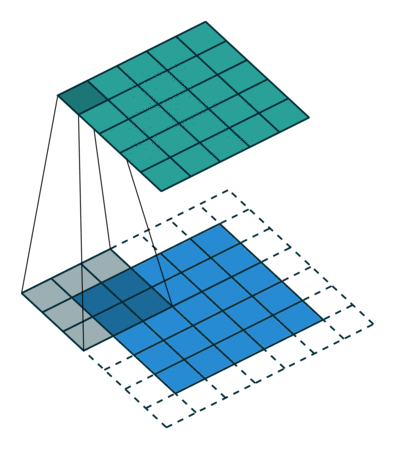

Above: Example convolutional filter. Image courtesy of [Sumit Saha](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

Now we implement a basic convolutional neural network.

In [23]:
class CNN(nn.Module):
    def __init__(self):
        '''
        Initialize the torch.nn.Module and define some layers for future ues.

        Please use the following network structure:
        - conv layer with 5 output channels and kernel size 5
        - max pooling on 2 by 2 blocks with stride of 2
        - conv layer with 16 output channels and kernel size 5
        - max pooling on 2 by 2 blocks with stride of 2
        - linear (fully-connected) layer with 120 output dims
        - linear (fully-connected) layer with 84 output dims
        - linear (fully-connected) layer with 10 output dims

        After any convolutional or linear layer EXCEPT for the final output,
        we will use a relu activation.
        '''
        ## YOUR CODE HERE
        ## TODO: Define your layers
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        ## END YOUR CODE

    def forward(self, x):
        '''
        Compute a forward pass of your batch of images. Refer to the docstring
        for the init method for the order in which to call

        x: torch.Tensor of shape (batch_size, num_channels, width, height)
        returns: result of passing x through your network
        '''
        ## YOUR CODE HERE
        ## TODO: Call your convolutional layers, with activation and pooling.
        ## TODO: Flatten your output
        ## TODO: Call your linear layers, with activation.
        ## TODO: Remember NOT to call activation after final fully connected layer!
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        ## END YOUR CODE

In [24]:
num_epochs = 15
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=1e-3, momentum=0.9)

In [38]:
train(cnn, train_loader, val_loader, num_epochs, criterion, optimizer)

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  1	loss: 1439.262	time: 17.481	train acc: 0.1074	val acc: 0.1107


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  2	loss: 1435.085	time: 17.064	train acc: 0.1344	val acc: 0.1406


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  3	loss: 1380.532	time: 18.009	train acc: 0.2296	val acc: 0.2486


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  4	loss: 1239.182	time: 16.607	train acc: 0.2873	val acc: 0.3237


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  5	loss: 1164.194	time: 17.115	train acc: 0.3241	val acc: 0.3660


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  6	loss: 1112.534	time: 17.339	train acc: 0.3489	val acc: 0.3941


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  7	loss: 1083.353	time: 18.254	train acc: 0.3567	val acc: 0.3925


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  8	loss: 1059.217	time: 18.597	train acc: 0.3822	val acc: 0.4254


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  9	loss: 1036.727	time: 18.293	train acc: 0.3935	val acc: 0.4386


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 10	loss: 1015.825	time: 16.884	train acc: 0.3970	val acc: 0.4342


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 11	loss: 997.561	time: 17.060	train acc: 0.4205	val acc: 0.4703


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 12	loss: 976.390	time: 17.140	train acc: 0.4307	val acc: 0.4828


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 13	loss: 959.524	time: 17.651	train acc: 0.4410	val acc: 0.4830


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 14	loss: 942.342	time: 17.864	train acc: 0.4553	val acc: 0.5071


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 15	loss: 930.237	time: 19.196	train acc: 0.4631	val acc: 0.5110


In [18]:
fcnn_num_params = count_parameters(fcnn)
cnn_num_params = count_parameters(cnn)
print('FCNN Num Params:', fcnn_num_params)
print('CNN Num Params:', cnn_num_params)
print('Ratio:', cnn_num_params/fcnn_num_params)

FCNN Num Params: 308310
CNN Num Params: 61530
Ratio: 0.19957185949206968


So we've improved validation accuracy while using 80% fewer parameters. Nice!

### Part 4: Using ResNet for Classification

The network that we're implementing here is here is the residual network (ResNet), a CNN variant and one of the most important networks in modern computer vision.

The fundamental idea behind ResNet is the _skip connection_. In very deep neural networks, we frequently run into the _vanishing gradient problem_, where updates during backpropagation can be multiplied by very small numbers and result in the first few layers of the network learning very slowly. Skip connections rectify this problem by having outputs of some layers jump ahead and skip a few layers and get added in later on. This means that gradient updates have to travel back a shorter distance to update the earlier layers in the network.

The reason that it's called a residual network is because our residual blocks, instead of learning the function $f(x)$, instead learn the _residual_ $f(x) - x$. The input $x$ gets added back in using the skip connection.

For more details, try checking out the [original ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) or [this fantastic blog post](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8).

Because this is a fairly involved architecture, we will only ask you to implement a single residual block of a ResNet18 model.

In [25]:
class ResNetBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        '''
        Create a residual block for our ResNet18 architecture.

        Here is the expected network structure:
        - conv layer with
            out_channels=out_channels, 3x3 kernel, stride=stride
        - batchnorm layer
        - conv layer with
            out_channels=out_channels, 3x3 kernel, stride=1
        - batchnorm layer
        - shortcut layer:
            if either the stride is not 1 or the out_channels is not equal to in_channels:
                the shortcut layer is composed of two steps:
                - conv layer with
                    in_channels=in_channels, out_channels=out_channels, 3x3 kernel, stride=stride
                - batchnorm layer
            else:
                the shortcut layer should be an no-op

        All conv layers will have a padding of 1 and no bias term. To facilitate this, consider using
        the provided conv() helper function.
        When performing a forward pass, the ReLU activation should be applied after the first batchnorm layer
        and after the second batchnorm gets added to the shortcut.
        '''
        ## YOUR CODE HERE
        ## TODO: Initialize the block with a call to super and make your conv and batchnorm layers.
        ## TODO: Use some conditional logic when defining your shortcut layer
        ## For a no-op layer, consider creating an empty nn.Sequential()
        super(ResNetBlock, self).__init__()
        self.conv1 = self.conv(in_channels, out_channels, 3, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = self.conv(out_channels, out_channels, 3, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        ## END YOUR CODE

    def conv(self, in_channels, out_channels, kernel_size, stride):
        return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1, bias=False)

    def forward(self, x):
        '''
        Compute a forward pass of this batch of data on this residual block.

        x: batch of images of shape (batch_size, num_channels, width, height)
        returns: result of passing x through this block
        '''
        ## YOUR CODE HERE
        ## TODO: Call the first convolution, batchnorm, and activation
        ## TODO: Call the second convolution and batchnorm
        ## TODO: Also call the shortcut layer on the original input
        ## TODO: Sum the result of the shortcut and the result of the second batchnorm
        ## and apply your activation
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.relu(out)
        return out
        ## END YOUR CODE

class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=64,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.in_channels = 64
        self.layer1 = self.make_block(out_channels=64, stride=1, rep=2)
        self.layer2 = self.make_block(out_channels=128, stride=2, rep=2)
        self.layer3 = self.make_block(out_channels=256, stride=2, rep=2)
        self.layer4 = self.make_block(out_channels=512, stride=2, rep=2)
        self.linear = nn.Linear(512, num_classes)

    def make_block(self, out_channels, stride, rep):
        layers = []
        for stride in [stride, 1]:
            layers.append(ResNetBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 4)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

In [26]:
num_epochs = 15
resnet = ResNet18(num_classes = 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=1e-3, momentum=0.9)

Now that we have defined our model, feel free to use this `torchsummary` package function to visualize how an image is passed through the network and how the layers change the shape of the image. The final convolution layer should output a tensor of size `(32, 512, 4, 4)`, which is averaged, flattened, and passed through a fully connected layer to end up with a `(32, 10)` tensor of classification scores. To evaluate predictions, we simply take the `argmax` of our output.



In [27]:
resnet = resnet.to(device)
summary(resnet, input_size = (3, 32, 32), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,728
       BatchNorm2d-2           [32, 64, 32, 32]             128
            Conv2d-3           [32, 64, 32, 32]          36,864
       BatchNorm2d-4           [32, 64, 32, 32]             128
              ReLU-5           [32, 64, 32, 32]               0
            Conv2d-6           [32, 64, 32, 32]          36,864
       BatchNorm2d-7           [32, 64, 32, 32]             128
              ReLU-8           [32, 64, 32, 32]               0
       ResNetBlock-9           [32, 64, 32, 32]               0
           Conv2d-10           [32, 64, 32, 32]          36,864
      BatchNorm2d-11           [32, 64, 32, 32]             128
             ReLU-12           [32, 64, 32, 32]               0
           Conv2d-13           [32, 64, 32, 32]          36,864
      BatchNorm2d-14           [32, 64,

This model will take about 20 minutes to train. Make sure that you are connected to a GPU runtime for Colab or, if you have GPU on your computer, consider training locally. Watch out for Colab's runtime disconnecting; it shouldn't be a big problem for this homework, but make sure to keep the browser tab open while the models are training.

The staff implementation got a validation accuracy of ~60% after 1 training epoch. If your results are significantly worse than that, consider stopping your training run and debugging your model.

In [ ]:
train(resnet, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_resnet')

And there we have it! Just by adding these skip connections, we dramatically improved the classification accuracy compared to a vanilla CNN!

### Part 5: Optimizing Hyperparameters and Other Tricks

In this section, you will be trying to achieve a **validation accuracy** of **at least 90%** on the same CIFAR-10 Dataset. Below, we have provided code to allow you to change various properties of your model, training procedure, and dataset augmentation. You are allowed to use whatever you wish except loading in pretrained models. However, creating your own model architecture below using any of the tricks we have learnt in class is fair game.

Here are a couple ideas to get you started:
- Batch size
- Learning rate
- Optimizer
- Loss function
- Learning rate
- Number of epochs
- Image transform
- Different kinds of layers (dropout, batchnorm, etc.)

In [23]:
data_root = './data/cifar10'
train_size = 40000
val_size = 10000

## YOUR CODE HERE
## TODO: Modify the given transforms and hyperparameters
batch_size = 64

transform_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.95, 1.05)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transform_val = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
## END YOUR CODE

dataset = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=None,
)

assert train_size + val_size <= len(dataset), "Trying to sample too many elements!" \
    "Please lower the train or validation set sizes."
train_set, val_set, _ = torch.utils.data.random_split(
    dataset, [train_size, val_size, len(dataset) - train_size - val_size]
)

class CustomTransformDataset(torch.utils.data.Subset):
    def __init__(self, subset, transform=None):
        super(CustomTransformDataset, self).__init__(subset.dataset, subset.indices)
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]
        if self.transform:
            x = self.transform(x)
        return x, y

train_set = CustomTransformDataset(train_set, transform=transform_train)
val_set = CustomTransformDataset(val_set, transform=transform_val)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

Files already downloaded and verified


In [29]:
## YOUR CODE HERE
## TODO: Modify the given hyperparameters
num_epochs = 50
## Feel free to create a bigger resnet model, or use a completely different CNN architecture
## The goal of this problem is for you to apply all of the deep learning tricks we have learnt so far
## to try and maximize the validation accuracy on CIFAR-10 as much as possible.
final_cnn = ResNet18(num_classes = 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(final_cnn.parameters(), lr=0.01, momentum=0.9)
# TODO: Maybe add a learning rate scheduler?
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
## END YOUR CODE

train(final_cnn, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_final_cnn', scheduler)

beginning to train model


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  1	loss: 1057.237	time: 33.074	train acc: 0.4636	val acc: 0.4828


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  2	loss: 796.210	time: 33.780	train acc: 0.5923	val acc: 0.6153


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  3	loss: 639.965	time: 32.646	train acc: 0.6424	val acc: 0.6539


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  4	loss: 532.272	time: 33.979	train acc: 0.7367	val acc: 0.7326


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  5	loss: 452.557	time: 33.203	train acc: 0.7553	val acc: 0.7537


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  6	loss: 358.208	time: 32.580	train acc: 0.8005	val acc: 0.7908


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  7	loss: 330.403	time: 32.820	train acc: 0.8383	val acc: 0.8219


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  8	loss: 305.548	time: 33.120	train acc: 0.8470	val acc: 0.8329


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch  9	loss: 288.085	time: 32.713	train acc: 0.8501	val acc: 0.8345


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 10	loss: 268.084	time: 32.954	train acc: 0.8617	val acc: 0.8432


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 11	loss: 223.331	time: 33.675	train acc: 0.8923	val acc: 0.8624


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 12	loss: 208.142	time: 32.634	train acc: 0.9020	val acc: 0.8683


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 13	loss: 199.048	time: 33.032	train acc: 0.9057	val acc: 0.8696


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 14	loss: 188.425	time: 33.246	train acc: 0.9063	val acc: 0.8694


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 15	loss: 182.573	time: 32.806	train acc: 0.9163	val acc: 0.8765


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 16	loss: 152.640	time: 33.141	train acc: 0.9319	val acc: 0.8845


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 17	loss: 141.796	time: 33.254	train acc: 0.9317	val acc: 0.8868


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 18	loss: 140.323	time: 33.324	train acc: 0.9332	val acc: 0.8837


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 19	loss: 132.104	time: 33.109	train acc: 0.9366	val acc: 0.8899


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 20	loss: 129.436	time: 33.339	train acc: 0.9421	val acc: 0.8865


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 21	loss: 112.189	time: 32.833	train acc: 0.9521	val acc: 0.8936


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 22	loss: 105.525	time: 32.743	train acc: 0.9534	val acc: 0.8952


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 23	loss: 104.434	time: 33.225	train acc: 0.9566	val acc: 0.8969


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 24	loss: 97.499	time: 32.886	train acc: 0.9574	val acc: 0.8971


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 25	loss: 97.549	time: 33.349	train acc: 0.9573	val acc: 0.8980


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 26	loss: 89.109	time: 33.471	train acc: 0.9624	val acc: 0.9001


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 27	loss: 84.022	time: 32.891	train acc: 0.9625	val acc: 0.9025


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 28	loss: 83.383	time: 33.201	train acc: 0.9641	val acc: 0.9006


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 29	loss: 80.996	time: 33.294	train acc: 0.9648	val acc: 0.9005


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 30	loss: 81.095	time: 32.725	train acc: 0.9637	val acc: 0.8996


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 31	loss: 76.599	time: 33.210	train acc: 0.9676	val acc: 0.9006


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 32	loss: 74.512	time: 33.963	train acc: 0.9696	val acc: 0.9009


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 33	loss: 72.882	time: 32.774	train acc: 0.9689	val acc: 0.9017


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 34	loss: 72.821	time: 33.478	train acc: 0.9697	val acc: 0.9013


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 35	loss: 70.513	time: 33.313	train acc: 0.9695	val acc: 0.9041


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 36	loss: 69.531	time: 32.841	train acc: 0.9705	val acc: 0.9016


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 37	loss: 67.556	time: 33.388	train acc: 0.9714	val acc: 0.9011


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 38	loss: 68.278	time: 33.004	train acc: 0.9706	val acc: 0.9015


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 39	loss: 68.566	time: 34.467	train acc: 0.9717	val acc: 0.9030


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 40	loss: 66.710	time: 33.249	train acc: 0.9718	val acc: 0.9018


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 41	loss: 64.767	time: 33.418	train acc: 0.9713	val acc: 0.9031


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 42	loss: 66.282	time: 33.701	train acc: 0.9735	val acc: 0.9031


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 43	loss: 65.235	time: 33.738	train acc: 0.9740	val acc: 0.9032


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 44	loss: 64.518	time: 33.350	train acc: 0.9731	val acc: 0.9036


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 45	loss: 64.087	time: 33.620	train acc: 0.9731	val acc: 0.9015


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 46	loss: 66.180	time: 33.077	train acc: 0.9728	val acc: 0.9022


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 47	loss: 63.683	time: 33.517	train acc: 0.9729	val acc: 0.9034


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 48	loss: 64.192	time: 33.863	train acc: 0.9733	val acc: 0.9041


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 49	loss: 61.991	time: 33.091	train acc: 0.9725	val acc: 0.9042


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

epoch 50	loss: 63.035	time: 34.413	train acc: 0.9738	val acc: 0.9016


### Part 6: Autograder and Submission

After you feel confident that you have a decent model, run the cell below.

Feel free to read the code block but **PLEASE DO NOT TOUCH IT**: this will produce a pickle file that will contain your model's predictions on the CIFAR-10 validation set --- tampering with the code block below might mess up the file that you will submit to the Gradescope autograder.

In [ ]:
import pickle

cifar_test = datasets.CIFAR10('.', download = True, train = False, transform = transform_val)
loader_test = DataLoader(cifar_test, batch_size=32, shuffle=False)

final_cnn.eval()  # set model to evaluation mode
predictions = []
with torch.no_grad():
    for x, _ in loader_test:
        x = x.to(device=device)  # move to device, e.g. GPU
        scores = final_cnn(x)
        _, preds = scores.max(1)
        predictions.append(preds)
predictions = torch.cat(predictions).tolist()
with open("my_predictions.pickle", "wb") as file:
    pickle.dump(predictions, file)

In [ ]:
from google.colab import files
files.download('my_predictions.pickle')